### Power Spectrum and Frequency Band Analysis

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from scipy.signal import welch

##### Overview  
  
The purpose of this notebook is to get some initial power spectrum and frequency band analysis work done with scipy's welch function. Before transforming the time series signal data into the frequency domain with welch, I will standardize and perform PCA on sub EEGs split by left and right hemisphere electrodes.

In [17]:
df = pd.read_csv('working_data.csv')

##### Splitting Data by Target Variable Class

In [18]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')
other_df = activity_df('Other')

##### Functions to Read and Standardize and Perform PCA on Sub EEGs

In [19]:
def scale(df, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][row]), engine = 'pyarrow')
    first_row = int(df['eeg_label_offset_seconds'][row] * 200)
    last_row = int(first_row + 10000)
    sub_eeg = eeg[first_row: last_row]
    electrodes = sub_eeg.columns
    scaler = StandardScaler()
    sub_eeg = scaler.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = electrodes)
    return sub_eeg

def pca_function(sub_eeg, group, n):
    sub_eeg = sub_eeg[group]
    pca = PCA(n_components = n, random_state = 42)
    sub_eeg = pca.fit_transform(sub_eeg)
    ratio = pca.explained_variance_ratio_
    sub_eeg = pd.DataFrame(sub_eeg, columns = ['component_{}'.format(i) for i in range(n)])
    return sub_eeg, ratio

def ica_function(sub_eeg, group):
    sub_eeg = sub_eeg[group]
    ica = FastICA(max_iter = 500, random_state = 32)
    sub_eeg = ica.fit_transform(sub_eeg)
    sub_eeg = pd.DataFrame(sub_eeg, columns = ['component_{}'.format(i) for i in range(len(group))])
    return sub_eeg

##### Functions for Performing Welch Transformation and Plotting Power Spectrum

In [20]:
def welch_function(sub_eeg, sampling_frequency, window_seconds):
    components = sub_eeg.columns
    win = window_seconds * sampling_frequency # 200 rows per second times number of seconds
    freqs = []
    power_spectrums = []
    for component in components:
        f, pxx = welch(sub_eeg[component], sampling_frequency, nperseg = win)
        freqs.append(f)
        power_spectrums.append(pxx)
    return np.asarray(freqs), np.asarray(power_spectrums)

def power_spectrum_dataframe(pxx_list, group):
    pxx_list = pd.DataFrame(pxx_list).transpose()
    pxx_list.columns = ['{}_Component{}'.format(group, i) for i in range(pxx_list.shape[1])]
    return pxx_list

def frequency_dataframe(f_list, group):
    f_list = pd.DataFrame(f_list).transpose()
    f_list.columns = ['{}_frequency{}'.format(group, i) for i in range(f_list.shape[1])]
    return f_list

def plot_power_spectrum(f_list, psd_list, h, w):
    power_cols = psd_list[0].columns
    frequency_cols = f_list[0].columns
    fig, axs = plt.subplots(len(power_cols), len(psd_list))
    fig.set_figheight(h)
    fig.set_figwidth(w)
    fig.tight_layout()
    for i in range(len(power_cols)):
        if len(psd_list) == 1:
            pxx_components = psd_list[0].columns
            f_components = f_list[0].columns
            axs[i].semilogy(np.asarray(f_list[0][f_components[i]]),
                            np.asarray(psd_list[0][pxx_components[i]]))
            axs[i].set_title('{}'.format(pxx_components[i]))
        else:
            for j in range(len(psd_list)):
                pxx_components = psd_list[j].columns
                f_components = f_list[j].columns
                axs[i][j].plot(np.asarray(f_list[j][f_components[i]]),
                               np.asarray(psd_list[j][pxx_components[i]]))
                axs[i][j].set_title('{}'.format(pxx_components[i]))
    plt.show()

##### Testing

In [21]:
left = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz']
right = ['Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2']

In [9]:
grda_left1, grda_left1_ratio = pca_function(scale(grda_df, 0), left, 3)
grda_right1, grda_right1_ratio = pca_function(scale(grda_df, 0), right, 3)

In [10]:
left_f, left_pxx = welch_function(grda_left1, 200, 4)
right_f, right_pxx = welch_function(grda_right1, 200, 4)

In [11]:
left_pxx = power_spectrum_dataframe(left_pxx, 'Left')
right_pxx = power_spectrum_dataframe(right_pxx, 'Right')

In [12]:
left_f = frequency_dataframe(left_f, 'Left')
right_f = frequency_dataframe(right_f, 'Right')

In [13]:
left_f1 = np.asarray(left_f['Left_frequency0'])
left_pxx1 = np.asarray(left_pxx['Left_Component0'])

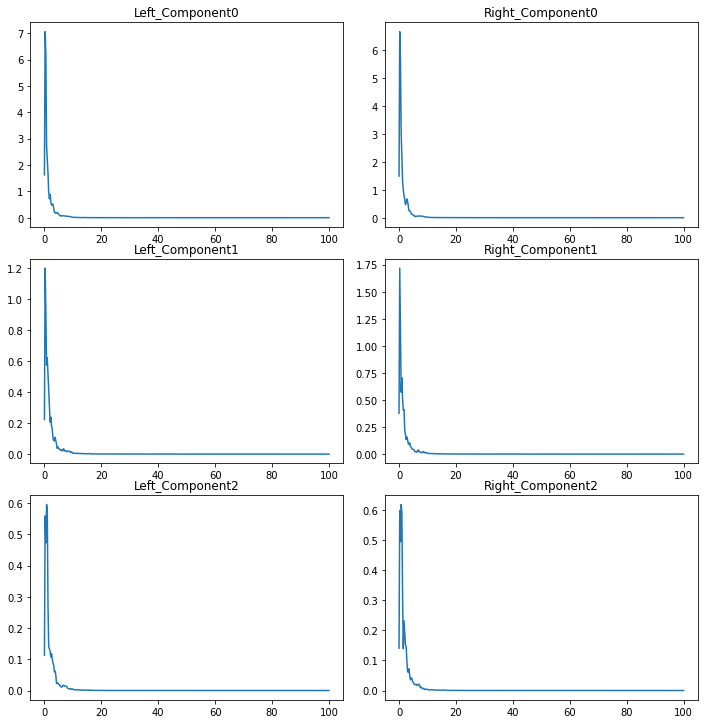

In [14]:
plot_power_spectrum([left_f, right_f], [left_pxx, right_pxx], 10, 10)

##### Seizure

In [15]:
seizure_indexes = [i for i in range(seizure_df.shape[0])]
seizure_randoms = np.random.choice(seizure_indexes, size = 5, replace = False)

In [16]:
seizure_left1, seizure_left1_ratio = pca_function(scale(seizure_df, seizure_randoms[0]), left, 3)
seizure_right1, seizure_right1_ratio = pca_function(scale(seizure_df, seizure_randoms[0]), right, 3)
seizure_left2, seizure_left2_ratio = pca_function(scale(seizure_df, seizure_randoms[1]), left, 3)
seizure_right2, seizure_right2_ratio = pca_function(scale(seizure_df, seizure_randoms[1]), right, 3)
seizure_left3, seizure_left3_ratio = pca_function(scale(seizure_df, seizure_randoms[2]), left, 3)
seizure_right3, seizure_right3_ratio = pca_function(scale(seizure_df, seizure_randoms[2]), right, 3)
seizure_left4, seizure_left4_ratio = pca_function(scale(seizure_df, seizure_randoms[3]), left, 3)
seizure_right4, seizure_right4_ratio = pca_function(scale(seizure_df, seizure_randoms[3]), right, 3)
seizure_left5, seizure_left5_ratio = pca_function(scale(seizure_df, seizure_randoms[4]), left, 3)
seizure_right5, seizure_right5_ratio = pca_function(scale(seizure_df, seizure_randoms[4]), right, 3)

In [17]:
left_seizure_f1, left_seizure_pxx1 = welch_function(seizure_left1, 200, 4)
right_seizure_f1, right_seizure_pxx1 = welch_function(seizure_right1, 200, 4)

##### Seizure Left/Right 1

In [18]:
left_seizure_pxx1 = power_spectrum_dataframe(left_seizure_pxx1, 'Left')
right_seizure_pxx1 = power_spectrum_dataframe(right_seizure_pxx1, 'Right')
left_seizure_f1  = frequency_dataframe(left_seizure_f1, 'Left')
right_seizure_f1 = frequency_dataframe(right_seizure_f1, 'Right')

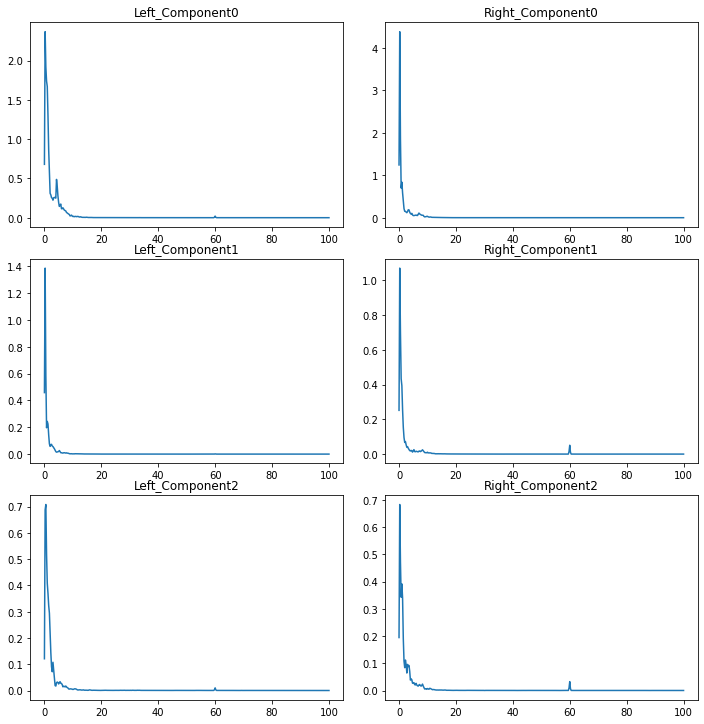

In [19]:
plot_power_spectrum([left_seizure_f1, right_seizure_f1], [left_seizure_pxx1, right_seizure_pxx1], 10, 10)

##### Seizure Left/Right 2

In [20]:
left_seizure_f2, left_seizure_pxx2 = welch_function(seizure_left2, 200, 4)
right_seizure_f2, right_seizure_pxx2 = welch_function(seizure_right2, 200, 4)

In [21]:
left_seizure_pxx2 = power_spectrum_dataframe(left_seizure_pxx2, 'Left')
right_seizure_pxx2 = power_spectrum_dataframe(right_seizure_pxx2, 'Right')
left_seizure_f2  = frequency_dataframe(left_seizure_f2, 'Left')
right_seizure_f2 = frequency_dataframe(right_seizure_f2, 'Right')

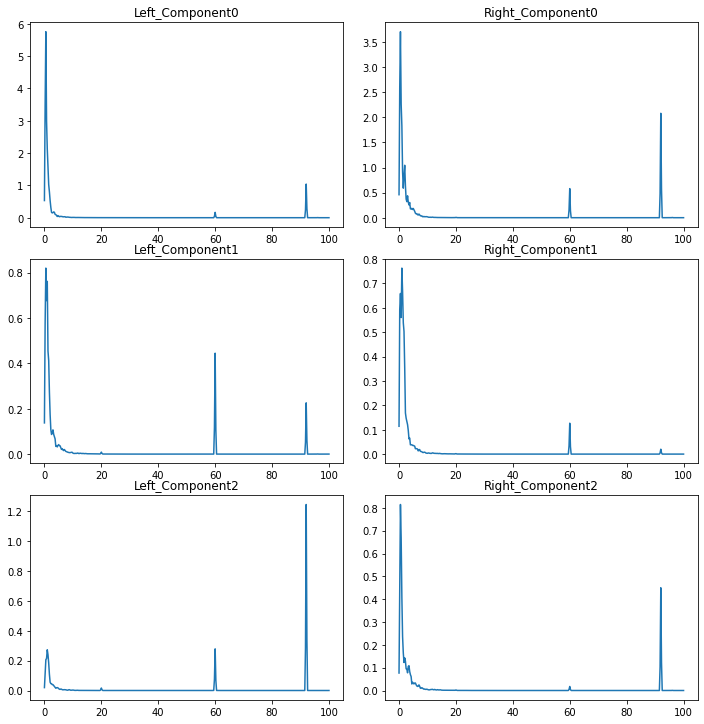

In [22]:
plot_power_spectrum([left_seizure_f2, right_seizure_f2], [left_seizure_pxx2, right_seizure_pxx2], 10, 10)

##### Seizure Left/Right 3

In [23]:
left_seizure_f3, left_seizure_pxx3 = welch_function(seizure_left3, 200, 4)
right_seizure_f3, right_seizure_pxx3 = welch_function(seizure_right3, 200, 4)

In [24]:
left_seizure_pxx3 = power_spectrum_dataframe(left_seizure_pxx3, 'Left')
right_seizure_pxx3 = power_spectrum_dataframe(right_seizure_pxx3, 'Right')
left_seizure_f3  = frequency_dataframe(left_seizure_f3, 'Left')
right_seizure_f3 = frequency_dataframe(right_seizure_f3, 'Right')

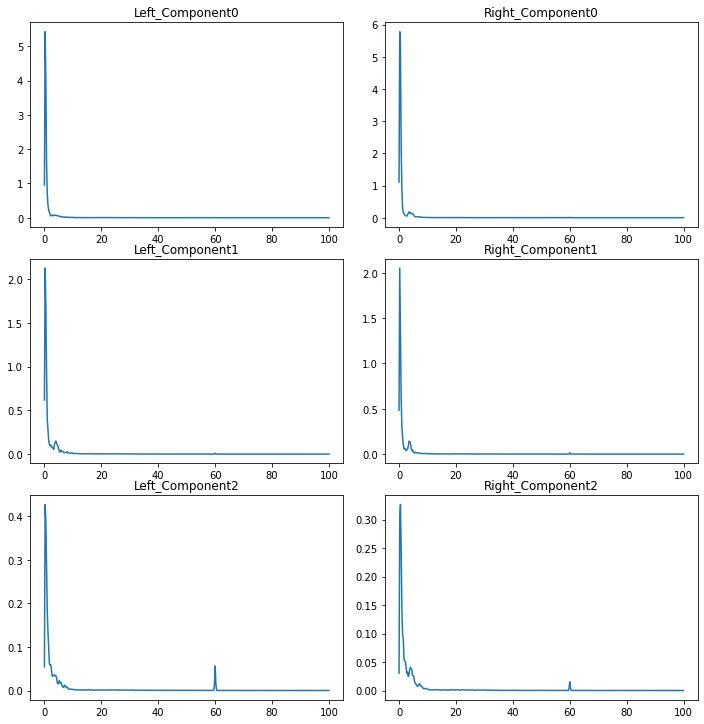

In [25]:
plot_power_spectrum([left_seizure_f3, right_seizure_f3], [left_seizure_pxx3, right_seizure_pxx3], 10, 10)

##### Seizure Left/Right 4

In [26]:
left_seizure_f4, left_seizure_pxx4 = welch_function(seizure_left4, 200, 4)
right_seizure_f4, right_seizure_pxx4 = welch_function(seizure_right4, 200, 4)

In [27]:
left_seizure_pxx4 = power_spectrum_dataframe(left_seizure_pxx4, 'Left')
right_seizure_pxx4 = power_spectrum_dataframe(right_seizure_pxx4, 'Right')
left_seizure_f4  = frequency_dataframe(left_seizure_f4, 'Left')
right_seizure_f4 = frequency_dataframe(right_seizure_f4, 'Right')

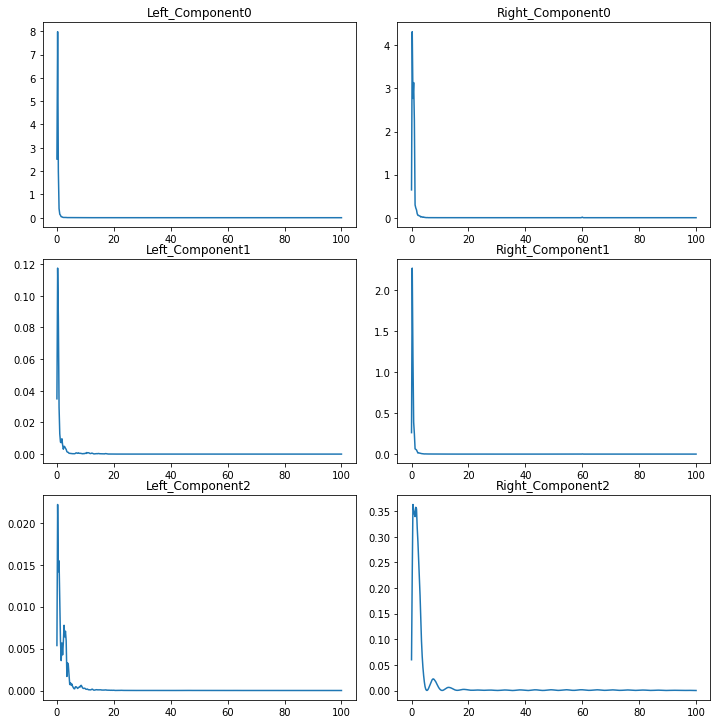

In [28]:
plot_power_spectrum([left_seizure_f4, right_seizure_f4], [left_seizure_pxx4, right_seizure_pxx4], 10, 10)

##### Seizure Left/Right 5

In [29]:
left_seizure_f5, left_seizure_pxx5 = welch_function(seizure_left5, 200, 4)
right_seizure_f5, right_seizure_pxx5 = welch_function(seizure_right5, 200, 4)

In [30]:
left_seizure_pxx5 = power_spectrum_dataframe(left_seizure_pxx5, 'Left')
right_seizure_pxx5 = power_spectrum_dataframe(right_seizure_pxx5, 'Right')
left_seizure_f5  = frequency_dataframe(left_seizure_f5, 'Left')
right_seizure_f5 = frequency_dataframe(right_seizure_f5, 'Right')

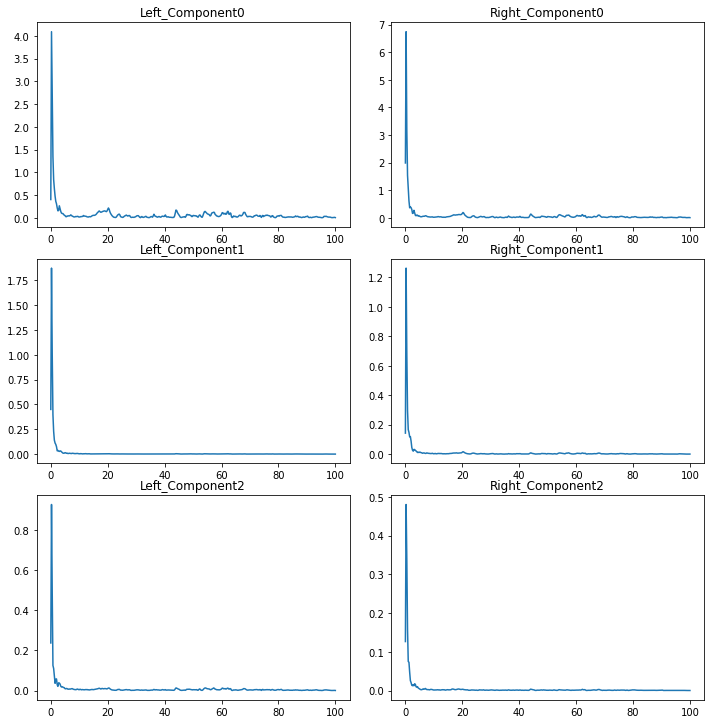

In [31]:
plot_power_spectrum([left_seizure_f5, right_seizure_f5], [left_seizure_pxx5, right_seizure_pxx5], 10, 10)

##### LRDA

In [32]:
lrda_indexes = [i for i in range(lrda_df.shape[0])]
lrda_randoms = np.random.choice(lrda_indexes, size = 5, replace = False)

lrda_left1, lrda_left1_ratio = pca_function(scale(lrda_df, lrda_randoms[0]), left, 3)
lrda_right1, lrda_right1_ratio = pca_function(scale(lrda_df, lrda_randoms[0]), right, 3)
lrda_left2, lrda_left2_ratio = pca_function(scale(lrda_df, lrda_randoms[1]), left, 3)
lrda_right2, lrda_right2_ratio = pca_function(scale(lrda_df, lrda_randoms[1]), right, 3)
lrda_left3, lrda_left3_ratio = pca_function(scale(lrda_df, lrda_randoms[2]), left, 3)
lrda_right3, lrda_right3_ratio = pca_function(scale(lrda_df, lrda_randoms[2]), right, 3)
lrda_left4, lrda_left4_ratio = pca_function(scale(lrda_df, lrda_randoms[3]), left, 3)
lrda_right4, lrda_right4_ratio = pca_function(scale(lrda_df, lrda_randoms[3]), right, 3)
lrda_left5, lrda_left5_ratio = pca_function(scale(lrda_df, lrda_randoms[4]), left, 3)
lrda_right5, lrda_right5_ratio = pca_function(scale(lrda_df, lrda_randoms[4]), right, 3)

##### LRDA Left/Right 1

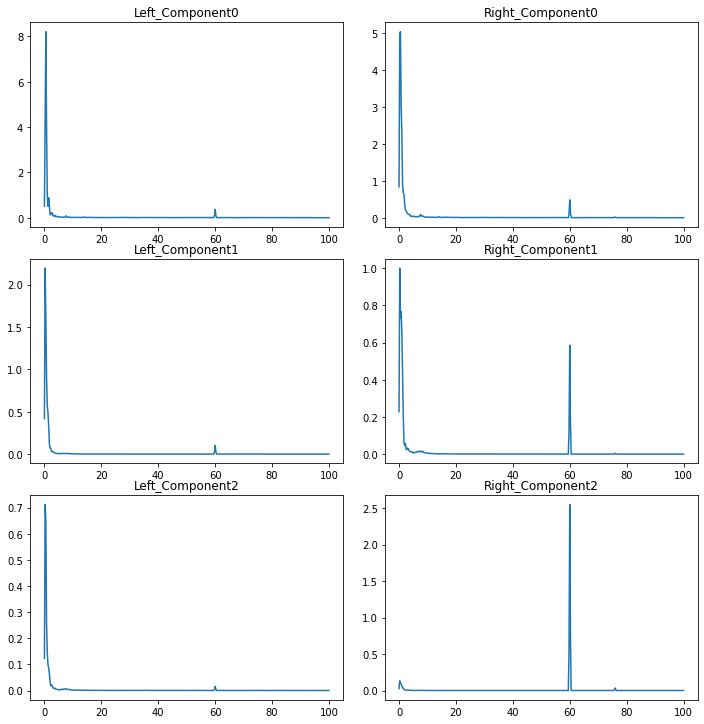

In [33]:
left_lrda_f1, left_lrda_pxx1 = welch_function(lrda_left1, 200, 4)
right_lrda_f1, right_lrda_pxx1 = welch_function(lrda_right1, 200, 4)

left_lrda_pxx1 = power_spectrum_dataframe(left_lrda_pxx1, 'Left')
right_lrda_pxx1 = power_spectrum_dataframe(right_lrda_pxx1, 'Right')
left_lrda_f1 = frequency_dataframe(left_lrda_f1, 'Left')
right_lrda_f1 = frequency_dataframe(right_lrda_f1, 'Right')

plot_power_spectrum([left_lrda_f1, right_lrda_f1], [left_lrda_pxx1, right_lrda_pxx1], 10, 10)

##### LRDA Left/Right 2

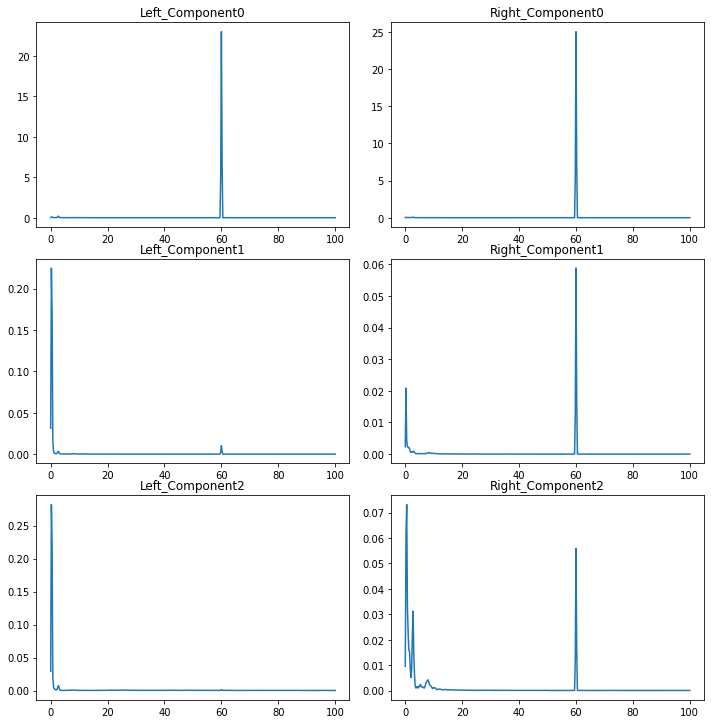

In [34]:
left_lrda_f2, left_lrda_pxx2 = welch_function(lrda_left2, 200, 4)
right_lrda_f2, right_lrda_pxx2 = welch_function(lrda_right2, 200, 4)

left_lrda_pxx2 = power_spectrum_dataframe(left_lrda_pxx2, 'Left')
right_lrda_pxx2 = power_spectrum_dataframe(right_lrda_pxx2, 'Right')
left_lrda_f2 = frequency_dataframe(left_lrda_f2, 'Left')
right_lrda_f2 = frequency_dataframe(right_lrda_f2, 'Right')

plot_power_spectrum([left_lrda_f2, right_lrda_f2], [left_lrda_pxx2, right_lrda_pxx2], 10, 10)

##### LRDA Left/Right 3

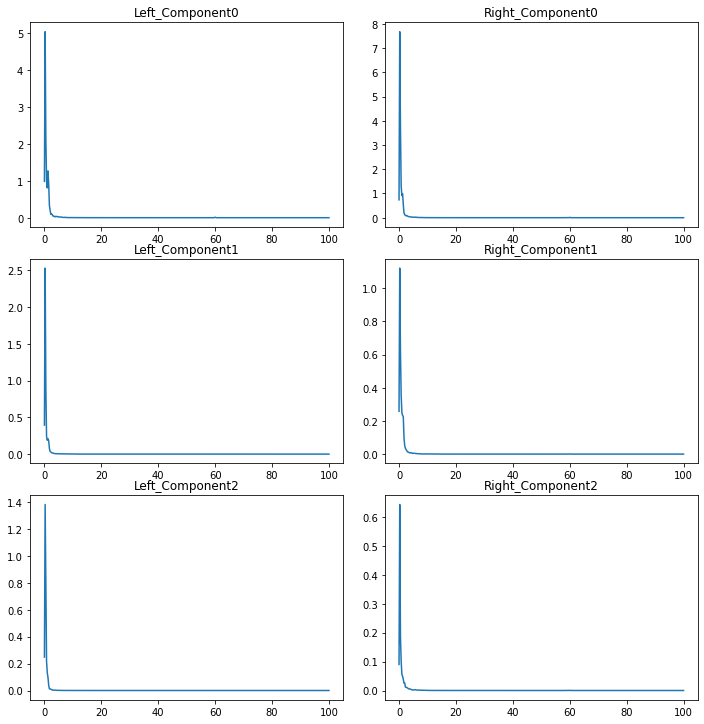

In [35]:
left_lrda_f3, left_lrda_pxx3 = welch_function(lrda_left3, 200, 4)
right_lrda_f3, right_lrda_pxx3 = welch_function(lrda_right3, 200, 4)

left_lrda_pxx3 = power_spectrum_dataframe(left_lrda_pxx3, 'Left')
right_lrda_pxx3 = power_spectrum_dataframe(right_lrda_pxx3, 'Right')
left_lrda_f3 = frequency_dataframe(left_lrda_f3, 'Left')
right_lrda_f3 = frequency_dataframe(right_lrda_f3, 'Right')

plot_power_spectrum([left_lrda_f3, right_lrda_f3], [left_lrda_pxx3, right_lrda_pxx3], 10, 10)

##### LRDA Left/Right 4

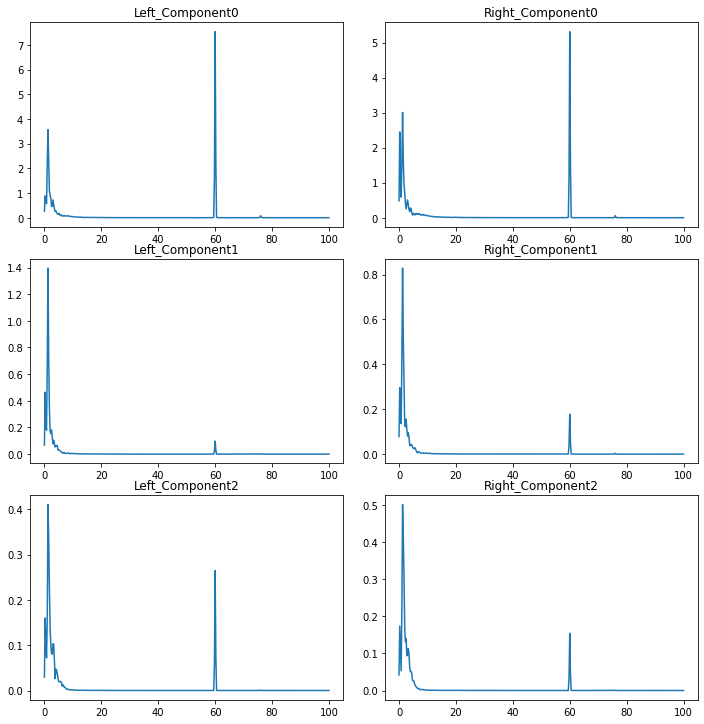

In [36]:
left_lrda_f4, left_lrda_pxx4 = welch_function(lrda_left4, 200, 4)
right_lrda_f4, right_lrda_pxx4 = welch_function(lrda_right4, 200, 4)

left_lrda_pxx4 = power_spectrum_dataframe(left_lrda_pxx4, 'Left')
right_lrda_pxx4 = power_spectrum_dataframe(right_lrda_pxx4, 'Right')
left_lrda_f4 = frequency_dataframe(left_lrda_f4, 'Left')
right_lrda_f4 = frequency_dataframe(right_lrda_f4, 'Right')

plot_power_spectrum([left_lrda_f4, right_lrda_f4], [left_lrda_pxx4, right_lrda_pxx4], 10, 10)

##### LRDA Left/Right 5

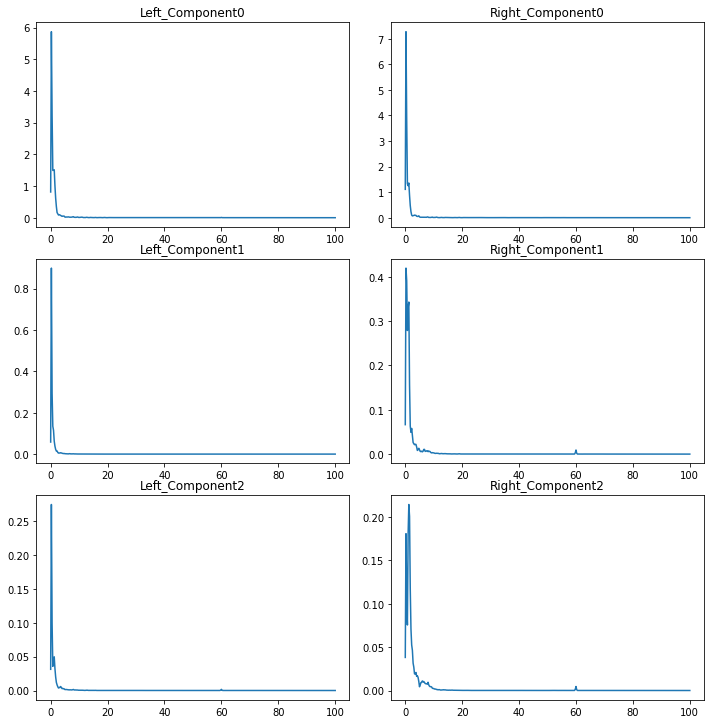

In [37]:
left_lrda_f5, left_lrda_pxx5 = welch_function(lrda_left5, 200, 4)
right_lrda_f5, right_lrda_pxx5 = welch_function(lrda_right5, 200, 4)

left_lrda_pxx5 = power_spectrum_dataframe(left_lrda_pxx5, 'Left')
right_lrda_pxx5 = power_spectrum_dataframe(right_lrda_pxx5, 'Right')
left_lrda_f5 = frequency_dataframe(left_lrda_f5, 'Left')
right_lrda_f5 = frequency_dataframe(right_lrda_f5, 'Right')

plot_power_spectrum([left_lrda_f5, right_lrda_f5], [left_lrda_pxx5, right_lrda_pxx5], 10, 10)

### Testing ICA Denoising

In [22]:
lrda_indexes = [i for i in range(lrda_df.shape[0])]
lrda_randoms = np.random.choice(lrda_indexes, size = 3, replace = False)

In [23]:
lrda_ica_left1 = ica_function(scale(lrda_df, lrda_randoms[0]), left)
lrda_ica_right1 = ica_function(scale(lrda_df, lrda_randoms[0]), right)
lrda_ica_left2 = ica_function(scale(lrda_df, lrda_randoms[1]), left)
lrda_ica_right2 = ica_function(scale(lrda_df, lrda_randoms[1]), right)
lrda_ica_left3 = ica_function(scale(lrda_df, lrda_randoms[2]), left)
lrda_ica_right3 = ica_function(scale(lrda_df, lrda_randoms[2]), right)

/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/home/clay/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


In [24]:
components = lrda_ica_left1.columns

##### LRDA 1

In [25]:
left_lrda_f1, left_lrda_pxx1 = welch_function(lrda_ica_left1, 200, 4)
right_lrda_f1, right_lrda_pxx1 = welch_function(lrda_ica_right1, 200, 4)

left_lrda_pxx1 = power_spectrum_dataframe(left_lrda_pxx1, 'Left')
right_lrda_pxx1 = power_spectrum_dataframe(right_lrda_pxx1, 'Right')
left_lrda_f1 = frequency_dataframe(left_lrda_f1, 'Left')
right_lrda_f1 = frequency_dataframe(right_lrda_f1, 'Right')

In [38]:
left_first6 = [left_lrda_pxx1.columns[i] for i in range(6)]
left_last5 = [left_lrda_pxx1.columns[i] for i in range(6, 11)]
right_first6 = [right_lrda_pxx1.columns[i] for i in range(6)]
right_last5 = [right_lrda_pxx1.columns[i] for i in range(6, 11)]
left_first6_df = left_lrda_pxx1[left_first6]
right_first6_df = right_lrda_pxx1[right_first6]
left_last5_df = left_lrda_pxx1[left_last5]
right_last5_df = right_lrda_pxx1[right_last5]

##### First 6 Independent Components  
  
Splitting independent components for easier visualization.

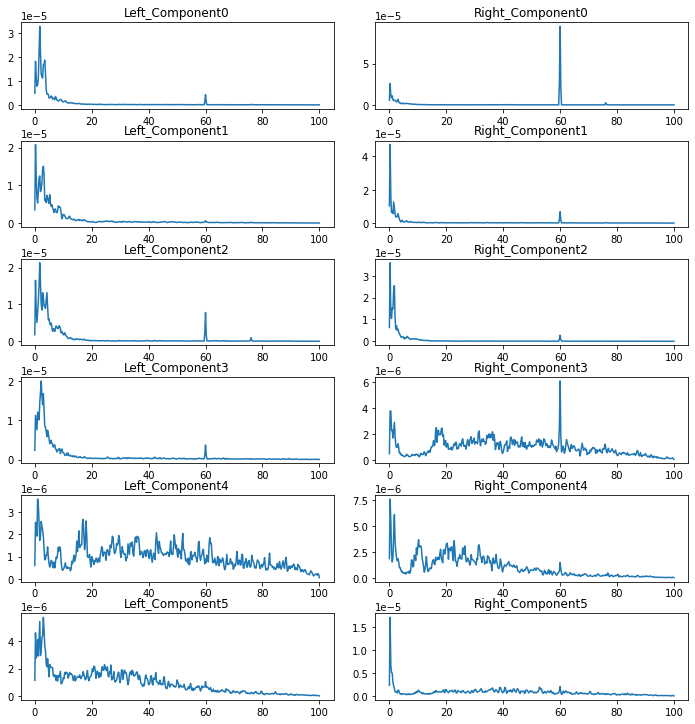

In [39]:
plot_power_spectrum([left_lrda_f1, right_lrda_f1], [left_first6_df, right_first6_df], 10, 10)

##### Last 5 Independent Components

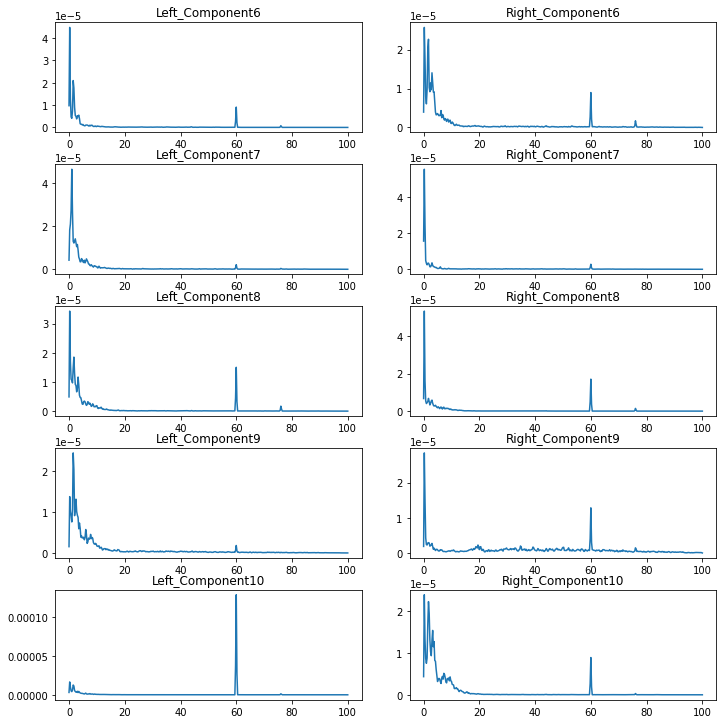

In [40]:
plot_power_spectrum([left_lrda_f1, right_lrda_f1], [left_last5_df, right_last5_df], 10, 10)

##### Quick Notes  
  
Left_Component10 is almost entirely a spike at 60 Hz. This is also true of Right_Component0. These spikes show up consistently for this LRDA sub EEG. I need to look into ICA for artifact removal more. My impression of the blink artifact example I watched last semester was that this is done manually. So, you do ICA, then you look at the resulting independent components to find the artifact and remove that component.  
  
I am likely misunderstanding that, though. If it is manual, I need a better method. Or to find the usual traits of independent components which would be removed and then write a function to identify and remove those components.